<a href="https://colab.research.google.com/github/mohamedghaly1/ECG-Detection-Using-EGRU/blob/main/Evaluation%20of%20LSTM%20and%20GRU%20(power-co2)%20/LSTM_GRU_metrics_perEpoch_ECG_ARRHYTHMIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/kaggle_dataset'

In [ ]:
%cd /content/gdrive/MyDrive/kaggle_dataset/

/content/gdrive/MyDrive/kaggle_dataset


In [ ]:
!ls

best_model.h5  heartbeat  kaggle.json


In [ ]:
!kaggle datasets download -d shayanfazeli/heartbeat

 92% 91.0M/98.8M [00:00<00:00, 119MB/s]
100% 98.8M/98.8M [00:00<00:00, 113MB/s]


In [ ]:
!mkdir heartbeat
!mv heartbeat.zip heartbeat

mkdir: cannot create directory ‘heartbeat’: File exists


In [ ]:
%cd heartbeat/

/content/gdrive/MyDrive/kaggle_dataset/heartbeat


In [ ]:
!unzip heartbeat.zip

Archive:  heartbeat.zip
replace mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install eco2ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.6.0 requires pandas>=1.5.0, but you have pandas 1.4.3 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.4.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.4.3 which is incompatible.
plotnine 0.12.4 requires pandas>=1.5.0, but you have pandas 1.4.3 whic

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import eco2ai
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load and Preprocess Data

In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_train.csv",header=None)
test_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_test.csv",header=None)
print(train_df[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


**Data Exploration and Visualization**

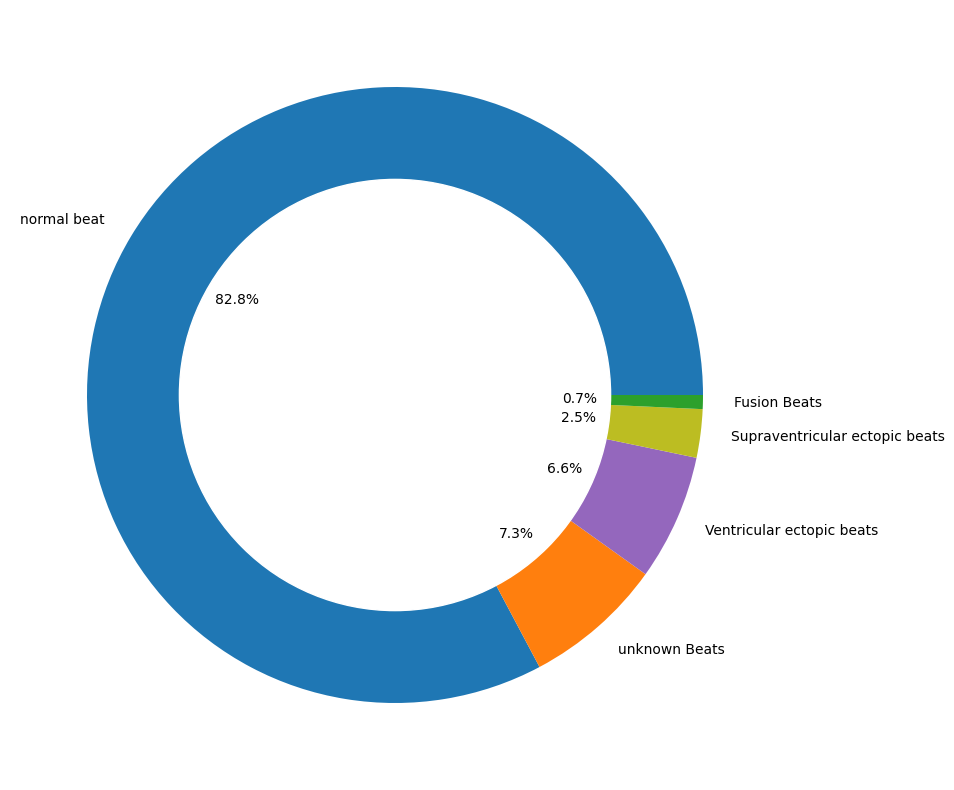

In [ ]:
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

**Class Balancing using SMOTE**

In [ ]:
from sklearn.utils import resample
df_1=train_df [train_df [187]==1]
df_2=train_df [train_df [187]==2]
df_3=train_df [train_df[187]==3]
df_4=train_df [train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=65000,random_state=42)
train_df=pd.concat([df_0,df_1,df_2,df_3,df_4])

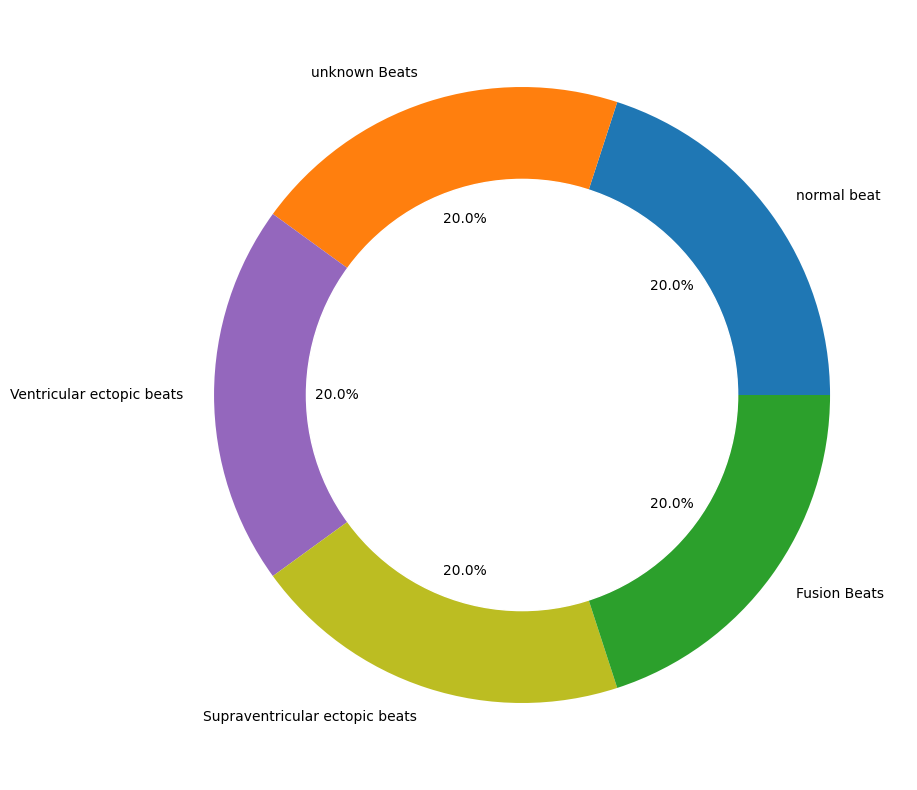

0.0    65000
1.0    65000
2.0    65000
3.0    65000
4.0    65000
Name: 187, dtype: int64


In [ ]:
# Separate features and target variable
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate the resampled data
train_df = pd.DataFrame(X_resampled)
train_df[187] = y_resampled

per_class = train_df[187].value_counts()
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat', 'unknown Beats', 'Ventricular ectopic beats', 'Supraventricular ectopic beats', 'Fusion Beats'], colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
print(train_df[187].value_counts())

**Display Sample ECG Signals**

In [ ]:
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
print("classes:",classes)

classes:              0         1         2         3         4         5         6    \
38511   0.959032  0.901304  0.452514  0.039106  0.083799  0.262570  0.305400   
140667  0.808585  0.709124  0.306901  0.039016  0.063595  0.096292  0.130741   
189553  1.000000  0.969057  0.775187  0.492711  0.282424  0.152317  0.076185   
217605  1.000000  0.958809  0.461033  0.202934  0.121040  0.097264  0.075403   
305925  1.000000  0.618800  0.378840  0.152873  0.078554  0.063573  0.076642   

             7         8         9    ...  178  179  180  181  182  183  184  \
38511   0.279330  0.275605  0.288641  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
140667  0.112051  0.136897  0.146195  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
189553  0.053564  0.062351  0.060208  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
217605  0.072790  0.064821  0.058751  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
305925  0.061218  0.075891  0.054905  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        185  186  187  
38511

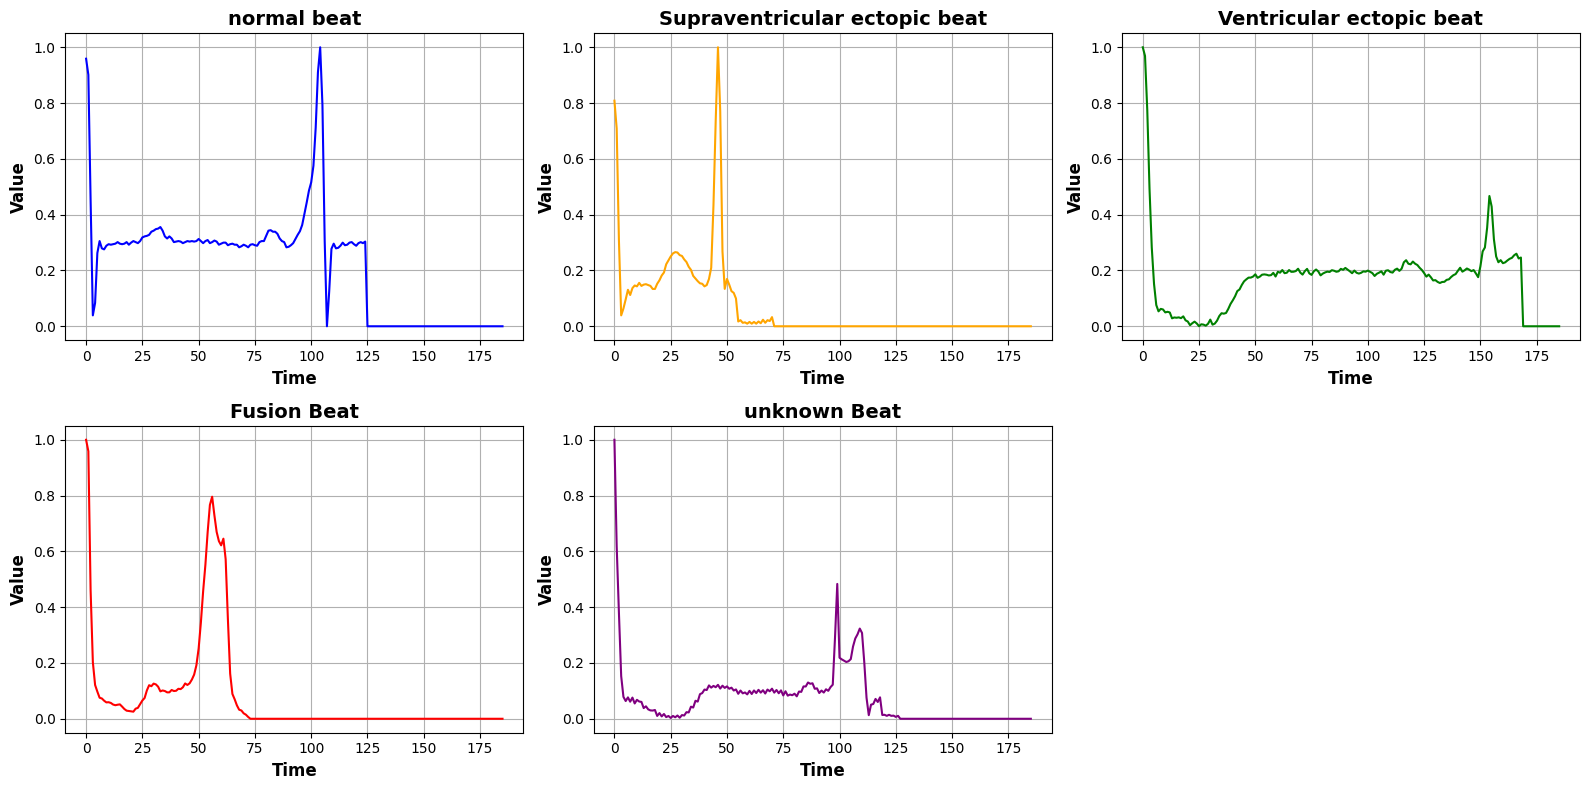

In [ ]:
# Define custom colors for each class
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(16, 8))

class_labels = ['normal beat', 'Supraventricular ectopic beat', 'Ventricular ectopic beat',
                'Fusion Beat','unknown Beat']

for i, label in enumerate(class_labels, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(data=classes.iloc[i-1, :186], color=colors[i-1])
    plt.title(label, fontsize=14, fontweight='bold')

    # Set labels and ticks
    plt.xlabel('Time', fontsize=12, fontweight='bold')
    plt.ylabel('Value', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

plt.tight_layout()
plt.show()

**Data setup for training and testing**

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

## **Model 1 (using LSTM)**

**LSTM Network**

In [ ]:
def lstm_network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_lstm = Input(shape=(im_shape), name='inputs_lstm')
    lstm1 = LSTM(128, return_sequences=True)(inputs_lstm)
    lstm1 = BatchNormalization()(lstm1)
    lstm2 = LSTM(64, return_sequences=True)(lstm1)
    lstm2 = BatchNormalization()(lstm2)
    lstm3 = LSTM(32)(lstm2)
    lstm3 = BatchNormalization()(lstm3)
    dense_end1 = Dense(32, activation='relu')(lstm3)
    dense_end1 = Dropout(0.2)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    dense_end2 = Dropout(0.2)(dense_end2)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs=inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=1, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model.h5')
    return model, history


**LSTM Evaluation Method**

In [ ]:
def lstm_evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

**Preparing for calculating power consumption**

In [ ]:
# Initialize eco2ai Tracker with project and experiment description
lstm_tracker = eco2ai.Tracker(project_name="Heartbeat Classification", experiment_description="Training EGRU model for heartbeat classification", file_name="lstm_emission.csv")

**Start training and testing the model**

In [ ]:
lstm_tracker.start()
start_time = time.time()
model,history=lstm_network(X_train,y_train,X_test,y_test)
current_time = time.time()
lstm_tracker.stop()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

10157/10157 [==============================] - 4575s 450ms/step - loss: 0.5071 - accuracy: 0.8191 - val_loss: 0.3640 - val_accuracy: 0.8839
Training Took: 76.54457034667332 minutes!


**Evaluation**

**Reviewing the Power consumption**

In [ ]:
df = pd.read_csv('lstm_emission.csv',sep =',')
df

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,a060091f-954f-4056-88b8-f97841905aaf,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-06-05 10:50:26,4592.857292,0.288158,0.162343,"Intel(R) Xeon(R) CPU @ 2.20GHz/1 device(s), TD...",0 device(s),Linux,TW/Taiwan,0


ower consumption per epoch = 0.2

CO2 emission = 0.16

## **Model 2 (using GRU)**

**GRU Network**

In [ ]:
def gru_network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_gru = Input(shape=(im_shape), name='inputs_gru')
    gru1 = GRU(128, return_sequences=True)(inputs_gru)
    gru1 = BatchNormalization()(gru1)
    gru2 = GRU(64, return_sequences=True)(gru1)
    gru2 = BatchNormalization()(gru2)
    gru3 = GRU(64)(gru2)
    gru3 = BatchNormalization()(gru3)
    dense_end1 = Dense(32, activation='relu')(gru3)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs=inputs_gru, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=1, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model.h5')

    return model, history

**GRU Evaluation Method**

In [ ]:
def gru_evaluate_model(history, X_test, y_test, model):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))

    print(history)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history.history['accuracy'], label='Training')
    sns.lineplot(data=history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history.history['loss'], label='Training')
    sns.lineplot(data=history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate confusion matrix
    y_true = [np.argmax(element) for element in y_test]
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

    # Normalize confusion matrix
    normalized_cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cnf_matrix, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()

**Preparing for calculating power consumption**

In [ ]:
# Initialize eco2ai Tracker with project and experiment description
gru_tracker = eco2ai.Tracker(project_name="Heartbeat Classification", experiment_description="Training EGRU model for heartbeat classification",file_name="gru_emission.csv")

**Start training and testing the model**

In [ ]:
gru_tracker.start()
start_time = time.time()
model, history = gru_network(X_train, y_train, X_test, y_test)
current_time = time.time()
gru_tracker.stop()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

10157/10157 [==============================] - 4064s 399ms/step - loss: 0.2704 - accuracy: 0.9028 - val_loss: 1.4937 - val_accuracy: 0.3053
Training Took: 68.5152429819107 minutes!


**Evaluation**

**Reviewing the Power consumption**

In [ ]:
df = pd.read_csv('gru_emission.csv',sep =',')
df

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,9d0e0195-7810-419c-ab18-f32245f39b33,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-06-05 12:08:26,4210.158798,0.261179,0.147143,"Intel(R) Xeon(R) CPU @ 2.20GHz/1 device(s), TD...",0 device(s),Linux,TW/Taiwan,0
1,f018f234-b1d1-4acc-b7bb-7e912847704a,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-06-05 12:08:57,4111.086663,0.262884,0.148104,"Intel(R) Xeon(R) CPU @ 2.20GHz/1 device(s), TD...",0 device(s),Linux,TW/Taiwan,0


power consumption per epoch = 0.2

CO2 emission = 0.14